# **CxC III - Infinite Investments Challenge**
### By the Secret Agents - Thirandie, Deepika, Lisa, Andy

Hi Judges! This is our first times ever interacting with anything related to Data Science, so we are just happy to be here and to learn more about the subject!

We have seperated our notebook into a few sections:
1. Preliminary Thoughts and Research
2. Data Preprocessing
3. Running the Model
4. Generating Answers
5. Analysis
6. Marketing Strategies
7. Final Thoughts

Our process was to first layout our data pipeline, running through all the steps earlier and getting to running the model and getting a Cross Validation score. Then, we went through all the steps again and it on the test dataset simotaneously.

## Part 1: Preliminary Thoughts and Research

In [1]:
# From Starting Docs - Importing Relevant history.csv from downloaded location in Personal Drive

import pandas as pd;
df = pd.read_csv("./history.csv")
test = pd.read_csv("./test.csv")

C:\Users\andyc\AppData\Local\Temp\ipykernel_30168\4255193893.py:4: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./history.csv")
C:\Users\andyc\AppData\Local\Temp\ipykernel_30168\4255193893.py:5: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("./test.csv")


Let's get some quick summary statistics on our history data set.

In [2]:
# This tells us the rows and columns there are in the dataset
df.shape

(673339, 106)

In [3]:
# As mentioned in the provided Python notebook, there is a lot more Churned customers than unchurned ones.
df.groupby(['label']).id.agg('count')

label
Churn       538444
No Churn    134895
Name: id, dtype: int64

In [4]:
# Another notable feature about this dataset is the amount of empty values there are - some columns have little to no data at all!
pd.options.display.max_rows = 128
df.isna().sum()

id                                         0
type_code                                237
is_registered                              0
country_code                          669050
currency_code                              0
is_active                                  0
class_id                                3198
debit_code                              3198
last_trade_date                       307875
contract_type                          95823
inception_date                          3198
net_of_fees                                0
cashflows_custody_fee                 673339
fee_paid_separately                        0
custody_fee_withdrawal                     0
is_fee_exempt                              0
branch                                  3198
include_client_consolidation               0
use_client_address                         0
credit_limit_type                       3198
retail_plan                           316985
is_spousal                            313694
is_arp_loc

In [5]:
# In Fact, there is no entry in this file without at least 1 empty column!
df_no_null = df.dropna()
df_no_null

,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label


Considering all the summary statistics, we have come to the following conclusions:

1. The missing values have to be dealt with, since without it there isn't much to do at all. We plan to deal with this by using the [MICE algorithm](https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.) for numerical and date data, and to just use the mode for categorical data. (We recognize that there are a lot of missing categorical data, so the mode might not be fully accurate - however it is reasonable enough a strategy)
2. As for the imbalanced dataset, we plan to take the advice given in the provided notebook and attempt to balance the dataset with Churn/No Churn entries before training the model. Fortunately, because Python, there does seem to be packages that handle this for us - namely [Imbalanced Learn](https://imbalanced-learn.org/stable/index.html)
3. To further reduce variance and to combat the effects of potentially errorenous preprocessing we will employ the Random Forest Classifier, as it randomly picks between columns and rows of data to use. This should hopefully improve the model's accuracy and recall.

## Part 2: Data Preprocessing

### Section 0: The Types of Columns we are dealing with
Before starting, we should replace unify all NaNs with `np.nan` for unifying reasons. We will also look at each of the columns to determine its type.

In [6]:
import numpy as np
null_mask = df.isna()
df[null_mask] = np.NaN

test_null_mask = test.isna()
test[test_null_mask] = np.NaN

df.head(3)

,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,NaN,CAD,t,5.0,C,2022-07-04,18.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,NaN,CAD,t,5.0,A,2018-07-05,16.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn


It looks the same, but we are assured that all the NaNs are now actually NaNs. As for the columns,

In [7]:
# We determine which of the columns are numerical vs categorical with the following code:

# Looking at the test data, it seems that some of the fields that seem to be numerical are actually categorical, which means manual tweaking!
numerical_cols = ['id', 'class_id', 'contract_type', 'cashflows_custody_fee', 'credit_limit_type', 
                  'dividend_confirm_code', 'options_trading_type', 'rep_commission_rate', 'rep_commission_override', 
                  'interest_dividend_conversion_type', 'guarantee_gtor_type', 'deceased_fair_market_value', 'target_grantor_grantee_flag', 
                  'esir_number', 'portfolio_cost_method', 'portfolio_report_option',
                  'interactive_portfolio_code', 'mailing_consent', 'number_of_beneficiaries', 'resp_specimen_plan']
categorical_cols = [
    col for col in df.columns
    if col not in numerical_cols
]

print("Numerical Columns: ", numerical_cols)
print("Categorical Columns: ", categorical_cols)

print("Number of numerical columns in the DataFrame:", len(numerical_cols))
print("Number of categorical columns in the DataFrame:", len(categorical_cols))

Numerical Columns:  ['id', 'class_id', 'contract_type', 'cashflows_custody_fee', 'credit_limit_type', 'dividend_confirm_code', 'options_trading_type', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'deceased_fair_market_value', 'target_grantor_grantee_flag', 'esir_number', 'portfolio_cost_method', 'portfolio_report_option', 'interactive_portfolio_code', 'mailing_consent', 'number_of_beneficiaries', 'resp_specimen_plan']
Categorical Columns:  ['type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'debit_code', 'last_trade_date', 'inception_date', 'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'include_client_consolidation', 'use_client_address', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'sss_location', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issue

Nominal columns are those that have words or a few categories in them. Notably, some of these columns contain names or something similar and so would have over thousands of categories. However, since there are a few entries with a lot of one type of entry it still would be important to keep that data in... to combat this we can introduce an additional category for 'infrequent' if there are not enough entries of that type. This value will be manually determined.

In [8]:
categorical_cols_nominals = ['type_code', 'country_code', 'currency_code', 'debit_code', 'branch', 'retail_plan', 'language_code', 'sss_agent', 'terminal_code', 'iso_funds_code',
                           'dup_trip_quad_code',  'special_tag', 'non_plan_book_value_flag', 'portfolio_summary_option',
                           'risk_tolerance', 'investment_objective', 'last_maintenance_user', 'portfolio_name_address_option',
                            'retail_last_maintenance_user', 'arp_pension_origin', 'conjunction', 'loan_limit_override', 'special_fee_code']
print("Number of categoricalcols_nominal in DataFrame:", len(categorical_cols_nominals))

Number of categoricalcols_nominal in DataFrame: 23


Nominal columns are those that have words or a few categories in them. Notably, some of these columns contain names or something similar and so would have over thousands of categories. However, since there are a few entries with a lot of one type of entry it still would be important to keep that data in... to combat this we can introduce an additional category for 'infrequent' if there are not enough entries of that type. This value will be manually determined.

In [9]:
categorical_cols_bools = ['is_registered', 'is_active', 'tms_settlement_location',
                         'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal',
                         'is_fee_exempt', 'include_client_consolidation', 'use_client_address',
                         'is_spousal',  'is_arp_locked', 'sss_location', 'sss_type', 'use_hand_delivery',
                          'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received',
                          'rrsp_limit_reached',  'is_portfolio_account', 'has_no_min_commission',
                          'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account',
                          'is_spousal_transfer', 'spousal_age_flag', 'has_multiple_name',
                          'discretionary_trading_authorized', 'shareholder_language', 'title',
                          'function_code',  'receive_general_mailings', 'has_discrete_auth',
                          'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info',
                          'consent_to_pay_for_mail', 'consent_to_email_delivery',
                          'has_received_instruction', 'is_broker_account',
                          'is_inventory_account', 'is_gl_account', 'is_control_account',
                          'is_extract_eligible', 'is_pledged', 'is_resp',
                          'use_original_date_for_payment_calc',  'is_family_resp',
                          'is_hrdc_resp',  'is_plan_grandfathered', 'is_olob', 'visible_in_reports', 'is_midwest_clearing_account']
print("Number of categoricalcols_bools in DataFrame:", len(categorical_cols_bools))

Number of categoricalcols_bools in DataFrame: 51


Boolean columns are those that are simple true and falses, which is nice! Of course the representation of T/F apparently differs but that is fine

In [10]:
categorical_cols_date = ['last_trade_date', 'inception_date', 'last_update_date', 'last_maintenance_time',  'non_calendar_year_end',
                         'plan_effective_date', 'plan_end_date',  'rrif_original_date',
                        'inserted_at',  'updated_at', 'retail_last_maintenance_time' ]

print("Number of categoricalcols_date in DataFrame:", len(categorical_cols_date))

Number of categoricalcols_date in DataFrame: 11


These Categorical Columns are actually Date columns, so we need to process them at a later date. From the names, it seems that turning them into numbers based off today's time would work as a transformation.

In [11]:
label_col = ['label']

Last but not least, we have our label column, which is the output.

### Section 1: Converting the Date Columns
Let's hope Python's Date Libraries are strong enough so that we don't have to put too much effort into converting them

In [12]:
for col in categorical_cols_date:
  # Convert date string into date object, then subtract today from it and get the seconds in between. If it can't be parsed right just ignore it
  # The hardest part about this was figuring out the timezone specifics but otherwise not bad
  df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
  df[col] = (df[col] - pd.Timestamp.now().tz_localize('UTC')).dt.total_seconds()

  test[col] = pd.to_datetime(test[col], errors='coerce', utc=True)
  test[col] = (test[col] - pd.Timestamp.now().tz_localize('UTC')).dt.total_seconds()

df

C:\Users\andyc\AppData\Local\Temp\ipykernel_30168\2808073438.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
C:\Users\andyc\AppData\Local\Temp\ipykernel_30168\2808073438.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test[col] = pd.to_datetime(test[col], errors='coerce', utc=True)


,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,NaN,-2.325738e+07,-1.719301e+07,f,NaN,NaN,f,Churn
1,1268094,RRIF,t,NaN,CAD,t,5.0,C,-5.182099e+07,18.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-3.600980e+07,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,NaN,CAD,t,5.0,A,-1.779650e+08,16.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-1.769282e+08,GUERINO,f,Churn
3,741930,CASH,f,NaN,CAD,t,3.0,T,NaN,12.0,...,NaN,NaN,NaN,-2.325738e+07,-1.719301e+07,f,NaN,NaN,t,Churn
4,1137922,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,NaN,-2.325738e+07,-1.718587e+07,f,NaN,NaN,f,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,LIRA/LRSP/RLSP,t,CAN,CAD,t,5.0,C,NaN,18.0,...,f,f,NaN,-2.078281e+07,-1.700284e+07,f,-2.080340e+07,BATCH,t,Churn
673335,590659,REG RRSP,t,NaN,CAD,f,5.0,A,-2.101058e+08,18.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-1.799522e+08,BATCH,f,No Churn
673336,1247774,CASH,f,NaN,CAD,t,3.0,T,-7.627219e+07,16.0,...,NaN,NaN,NaN,-2.325738e+07,-1.719301e+07,f,NaN,NaN,t,Churn
673337,1155640,RRIF,t,NaN,CAD,t,5.0,C,NaN,17.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-2.814740e+07,T80,t,Churn


### Section 2: Imputing the Non-numerical Columns
We are now ready to impute all missing values. To do this, we use the mode for nominal/boolean ones.

In [13]:
# Import the Simple Imputer for those Categorical items
from sklearn.impute import SimpleImputer

nominalToImpute = df[categorical_cols_nominals]
test_nominalToImpute = test[categorical_cols_nominals]

Imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
Imputer.set_output(transform="pandas")

nominalToImpute = Imputer.fit_transform(nominalToImpute)
test_nominalToImpute = Imputer.transform(test_nominalToImpute)
nominalToImpute

,type_code,country_code,currency_code,debit_code,branch,retail_plan,language_code,sss_agent,terminal_code,iso_funds_code,...,portfolio_summary_option,risk_tolerance,investment_objective,last_maintenance_user,portfolio_name_address_option,retail_last_maintenance_user,arp_pension_origin,conjunction,loan_limit_override,special_fee_code
0,CASH SWEEP,CAN,CAD,0,IAVM,RS,E,SEC 99999,BATCH,CAD,...,0.0,M99,G99,T80,0.0,BATCH,ON,NOT,CL,N
1,RRIF,CAN,CAD,C,IAVM,RI,E,SEC 99999,BATCH,CAD,...,0.0,H10M90,B05G85S10,BATCH,0.0,BATCH,ON,NOT,CL,N
2,SPOUSAL RRSP,CAN,CAD,A,IAVM,RS,F,SEC 99999,G023,CAD,...,0.0,H50M50S00,G50S50,GUERINO,0.0,GUERINO,ON,NOT,CL,N
3,CASH,CAN,CAD,T,IAVM,RS,E,SEC 99999,113C,CAD,...,0.0,M99,G99,T80,0.0,BATCH,ON,NOT,CL,N
4,CASH,CAN,CAD,T,IAVM,RS,E,SEC 99999,BATCH,CAD,...,0.0,M99,G99,H01,0.0,BATCH,ON,NOT,CL,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,LIRA/LRSP/RLSP,CAN,CAD,C,HOLIS,RS,E,SEC 99999,BATCH,CAD,...,0.0,M99,G99,BATCH,0.0,BATCH,FD,NOT,CL,N
673335,REG RRSP,CAN,CAD,A,IAVM,RS,F,SEC 99999,BATCH,CAD,...,0.0,M99,G99,ISLUSR,0.0,BATCH,ON,NOT,CL,N
673336,CASH,CAN,CAD,T,IAVM,RS,E,SEC 99999,BATCH,CAD,...,0.0,H25M75,G99,BATCH,0.0,BATCH,ON,NOT,CL,N
673337,RRIF,CAN,CAD,C,IAVM,RI,E,SEC 99999,107C,CAD,...,0.0,M99,G99,T80,0.0,T80,ON,NOT,CL,N


In [14]:
from sklearn.impute import SimpleImputer

boolsToImpute = df[categorical_cols_bools]
test_boolsToImpute = test[categorical_cols_bools]

boolImputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
boolImputer.set_output(transform="pandas")

boolsToImpute = boolImputer.fit_transform(boolsToImpute)
test_boolsToImpute = boolImputer.transform(test_boolsToImpute)
boolsToImpute

,is_registered,is_active,tms_settlement_location,net_of_fees,fee_paid_separately,custody_fee_withdrawal,is_fee_exempt,include_client_consolidation,use_client_address,is_spousal,...,is_extract_eligible,is_pledged,is_resp,use_original_date_for_payment_calc,is_family_resp,is_hrdc_resp,is_plan_grandfathered,is_olob,visible_in_reports,is_midwest_clearing_account
0,f,t,TOR,f,f,f,f,t,f,f,...,t,f,f,f,f,f,f,f,f,False
1,t,t,TOR,f,f,f,f,t,t,f,...,t,f,f,f,f,f,f,f,t,False
2,t,t,TOR,f,f,f,f,f,f,t,...,t,f,f,f,f,f,f,f,f,False
3,f,t,TOR,f,f,f,f,t,t,f,...,t,f,f,f,f,f,f,f,t,False
4,f,t,TOR,f,f,f,f,t,f,f,...,t,f,f,f,f,f,f,f,f,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,t,t,TOR,f,f,f,f,t,t,f,...,t,f,f,f,f,f,f,f,t,False
673335,t,f,TOR,f,f,f,f,t,f,f,...,t,f,f,f,f,f,f,f,f,False
673336,f,t,TOR,f,f,f,f,t,t,f,...,t,f,f,f,f,f,f,f,t,False
673337,t,t,TOR,f,f,f,f,t,t,f,...,t,f,f,f,f,f,f,f,t,False


In [15]:
# Merge them back in
df[categorical_cols_nominals] = nominalToImpute
df[categorical_cols_bools] = boolsToImpute

test[categorical_cols_nominals] = test_nominalToImpute
test[categorical_cols_bools] = test_boolsToImpute

df

,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,f,CAN,CAD,t,3.0,0,NaN,NaN,...,f,f,NaN,-2.325738e+07,-1.719301e+07,f,NaN,BATCH,f,Churn
1,1268094,RRIF,t,CAN,CAD,t,5.0,C,-5.182099e+07,18.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-3.600980e+07,BATCH,t,Churn
2,606613,SPOUSAL RRSP,t,CAN,CAD,t,5.0,A,-1.779650e+08,16.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-1.769282e+08,GUERINO,f,Churn
3,741930,CASH,f,CAN,CAD,t,3.0,T,NaN,12.0,...,f,f,NaN,-2.325738e+07,-1.719301e+07,f,NaN,BATCH,t,Churn
4,1137922,CASH,f,CAN,CAD,t,3.0,T,NaN,17.0,...,f,f,NaN,-2.325738e+07,-1.718587e+07,f,NaN,BATCH,f,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,LIRA/LRSP/RLSP,t,CAN,CAD,t,5.0,C,NaN,18.0,...,f,f,NaN,-2.078281e+07,-1.700284e+07,f,-2.080340e+07,BATCH,t,Churn
673335,590659,REG RRSP,t,CAN,CAD,f,5.0,A,-2.101058e+08,18.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-1.799522e+08,BATCH,f,No Churn
673336,1247774,CASH,f,CAN,CAD,t,3.0,T,-7.627219e+07,16.0,...,f,f,NaN,-2.325738e+07,-1.719301e+07,f,NaN,BATCH,t,Churn
673337,1155640,RRIF,t,CAN,CAD,t,5.0,C,NaN,17.0,...,f,f,NaN,-2.325738e+07,-1.700975e+07,f,-2.814740e+07,T80,t,Churn


### Section 3: One-Hot Encoding
Before imputing numerical values, we first one-hot encode everything else. However, as mentioned earlier, as some of the fields contain literally thousands of values we implement a method to get rid of categories that are not substantial.

Of course, since we backfilled our categorical data with the mode already, we need to be careful with what the cutoff should be. Manual checking from earlier suggests that maybe, uh, **500**? Also, we have to cap the max categories to 20 - otherwise we get like 1000 or so columns, which isn't great. Just so you know, 20 was deliberately chosen because of `type_code`

In [16]:
from sklearn.preprocessing import OneHotEncoder

nominalOneHot = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='infrequent_if_exist', min_frequency=500, max_categories=20)
nominalOneHot.set_output(transform="pandas")

nomOneHot = df[categorical_cols_nominals].astype(str)
test_nomOneHot = test[categorical_cols_nominals].astype(str)

nomOneHot = nominalOneHot.fit_transform(nomOneHot)
test_nomOneHot = nominalOneHot.transform(test_nomOneHot)

nomOneHot

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [7, 8, 13, 14, 15, 16, 17, 18, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,type_code_CASH SWEEP,type_code_COD,type_code_LIRA/LRSP/RLSP,type_code_MISSING,type_code_MRGN,type_code_OFFBOOK,type_code_RDSP,type_code_REG RRSP,type_code_RESP,type_code_RRIF,...,arp_pension_origin_FD,arp_pension_origin_MB,arp_pension_origin_NB,arp_pension_origin_ON,arp_pension_origin_QC,arp_pension_origin_SK,arp_pension_origin_infrequent_sklearn,conjunction_infrequent_sklearn,loan_limit_override_infrequent_sklearn,special_fee_code_infrequent_sklearn
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
673336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
673337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.preprocessing import OneHotEncoder

booleanOneHot = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='infrequent_if_exist', min_frequency=500)
booleanOneHot.set_output(transform="pandas")

boolOneHot = df[categorical_cols_bools].astype(str)
test_boolOneHot = test[categorical_cols_bools].astype(str)

boolOneHot = booleanOneHot.fit_transform(boolOneHot)
test_boolOneHot = booleanOneHot.transform(test_boolOneHot)

boolOneHot

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [28, 29, 50] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,is_registered_t,is_active_t,tms_settlement_location_DTC,tms_settlement_location_TOR,tms_settlement_location_infrequent_sklearn,net_of_fees_f,fee_paid_separately_f,custody_fee_withdrawal_f,is_fee_exempt_f,include_client_consolidation_t,...,is_extract_eligible_t,is_pledged_infrequent_sklearn,is_resp_t,use_original_date_for_payment_calc_t,is_family_resp_t,is_hrdc_resp_t,is_plan_grandfathered_f,is_olob_t,visible_in_reports_t,is_midwest_clearing_account_False
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
673335,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
673336,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
673337,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [18]:
# Merge them back in
df = pd.concat([df, nomOneHot, boolOneHot], axis=1)
df = df.drop(categorical_cols_nominals, axis=1).drop(categorical_cols_bools, axis=1)

test = pd.concat([test, test_nomOneHot, test_boolOneHot], axis=1)
test = test.drop(categorical_cols_nominals, axis=1).drop(categorical_cols_bools, axis=1)

df

,id,class_id,last_trade_date,contract_type,inception_date,cashflows_custody_fee,credit_limit_type,dividend_confirm_code,options_trading_type,rep_commission_rate,...,is_extract_eligible_t,is_pledged_infrequent_sklearn,is_resp_t,use_original_date_for_payment_calc_t,is_family_resp_t,is_hrdc_resp_t,is_plan_grandfathered_f,is_olob_t,visible_in_reports_t,is_midwest_clearing_account_False
0,893724,3.0,NaN,NaN,-2.056994e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1268094,5.0,-5.182099e+07,18.0,-1.670786e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,606613,5.0,-1.779650e+08,16.0,-4.695650e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,741930,3.0,NaN,12.0,-9.899539e+07,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1137922,3.0,NaN,17.0,-2.081186e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,5.0,NaN,18.0,-2.088979e+07,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
673335,590659,5.0,-2.101058e+08,18.0,-5.444738e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
673336,1247774,3.0,-7.627219e+07,16.0,-1.415906e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
673337,1155640,5.0,NaN,17.0,-2.081186e+08,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### Section 4: MICE Imputing
Now for the rest of the rows. MICE time.

In [19]:
# First, we need to cut off the label, since that isn't a number and MICE cannot handle it.
df_X = df.drop(['label'], axis=1)
df_Y = df['label']

# No label in Test!
test_X = test

In [20]:
# Apparently its still a experimental feature within sklearn - but that won't stop us!
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

total_num_cols = np.concatenate((numerical_cols, categorical_cols_date))

numImpute = IterativeImputer(random_state=23950, initial_strategy='median')
numImpute.set_output(transform="pandas")

toNumImpute = df_X[total_num_cols]
toNumImpute = numImpute.fit_transform(toNumImpute)

toNumImpute

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: [ 3 24]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,id,class_id,contract_type,credit_limit_type,dividend_confirm_code,options_trading_type,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,...,last_trade_date,inception_date,last_update_date,last_maintenance_time,plan_effective_date,plan_end_date,rrif_original_date,inserted_at,updated_at,retail_last_maintenance_time
0,893724.0,3.0,14.415885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.034469e+07,-2.056994e+08,-8.590901e+07,-6.910099e+07,-3.100958e+08,-4.821977e+09,-9.093112e+08,-2.325738e+07,-1.719301e+07,-5.706625e+09
1,1268094.0,5.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-5.182099e+07,-1.670786e+08,-4.611859e+07,-3.600979e+07,-1.670786e+08,-4.591844e+07,-1.670786e+08,-2.325738e+07,-1.700975e+07,-3.600980e+07
2,606613.0,5.0,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-1.779650e+08,-4.695650e+08,-3.105026e+08,-9.294739e+07,-4.695650e+08,-1.769282e+08,-4.695650e+08,-2.325738e+07,-1.700975e+07,-1.769282e+08
3,741930.0,3.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-8.337585e+07,-9.899539e+07,-9.899539e+07,-9.899539e+07,-8.497189e+07,-3.406795e+09,-8.029122e+08,-2.325738e+07,-1.719301e+07,-4.806123e+09
4,1137922.0,3.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.029380e+08,-2.081186e+08,-2.078594e+08,-2.088979e+07,-3.381639e+08,-4.578731e+09,-4.264582e+08,-2.325738e+07,-1.718587e+07,-4.509569e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067.0,5.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-6.547118e+07,-2.088979e+07,-2.088979e+07,-2.080339e+07,-2.088979e+07,-5.017152e+07,-2.088979e+07,-2.078281e+07,-1.700284e+07,-2.080340e+07
673335,590659.0,5.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-2.101058e+08,-5.444738e+08,-4.973858e+08,-1.307906e+08,-5.444738e+08,-2.084642e+08,-5.444738e+08,-2.325738e+07,-1.700975e+07,-1.799522e+08
673336,1247774.0,3.0,16.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.627219e+07,-1.415906e+08,-1.415906e+08,-1.411586e+08,-1.588691e+08,-3.714318e+09,-6.693150e+08,-2.325738e+07,-1.719301e+07,-4.682246e+09
673337,1155640.0,5.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-8.624546e+07,-2.081186e+08,-1.631042e+08,-2.814739e+07,-2.081186e+08,-7.118907e+07,-2.081186e+08,-2.325738e+07,-1.700975e+07,-2.814740e+07


In [21]:
# Because the Imputer ignored a few columns, we need to get rid of them from test too
test_toNumImpute = test_X[total_num_cols]
test_toNumImpute = numImpute.transform(test_toNumImpute)

test_toNumImpute

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: [ 3 24]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


,id,class_id,contract_type,credit_limit_type,dividend_confirm_code,options_trading_type,rep_commission_rate,rep_commission_override,interest_dividend_conversion_type,guarantee_gtor_type,...,last_trade_date,inception_date,last_update_date,last_maintenance_time,plan_effective_date,plan_end_date,rrif_original_date,inserted_at,updated_at,retail_last_maintenance_time
0,1155742.0,3.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.198729e+08,-2.081186e+08,-2.078594e+08,-5.095699e+07,-3.298518e+08,-4.485207e+09,-3.856433e+08,-2.325738e+07,-1.719301e+07,-4.366572e+09
1,1269359.0,5.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-1.041794e+08,-1.250018e+08,-1.250018e+08,-4.248979e+07,-1.250018e+08,-8.790960e+07,-1.250018e+08,-2.325738e+07,-1.700975e+07,-4.248980e+07
2,573181.0,3.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.220570e+07,-3.540499e+07,-3.540499e+07,-3.531859e+07,4.408194e+07,-2.805107e+09,-1.107351e+09,-2.325738e+07,-1.719301e+07,-5.201810e+09
3,967968.0,5.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-1.255202e+08,-2.081186e+08,-1.679426e+08,-8.050579e+07,-2.081186e+08,-1.243970e+08,-2.081186e+08,-2.325738e+07,-1.700975e+07,-8.050580e+07
4,595581.0,3.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.070978e+08,-4.737986e+08,-3.298579e+07,-2.520979e+07,-6.574632e+08,-4.476066e+09,1.153523e+08,-2.325738e+07,-1.718675e+07,-2.539596e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168330,1047726.0,3.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.809054e+08,-2.081186e+08,-2.078594e+08,-1.677698e+08,-3.021508e+08,-4.175154e+09,-2.229975e+08,-2.325738e+07,-1.719301e+07,-3.839366e+09
168331,888353.0,3.0,14.587338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.335008e+07,-2.056994e+08,-7.120984e+07,-2.218579e+07,-3.079590e+08,-4.841048e+09,-1.015163e+09,-2.325738e+07,-1.718611e+07,-5.960363e+09
168332,1090674.0,3.0,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.559203e+07,-7.653139e+07,-7.653139e+07,-2.616019e+07,-4.507189e+07,-3.305579e+09,-1.024497e+09,-2.325738e+07,-1.718697e+07,-5.235874e+09
168333,1034923.0,5.0,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,-2.022434e+08,-2.081186e+08,-2.078594e+08,-1.307042e+08,-2.081186e+08,-2.018114e+08,-2.081186e+08,-2.325738e+07,-1.700975e+07,-1.796930e+08


In [22]:
# Merge it in
df_X = df_X.drop(total_num_cols, axis=1)
df_X = pd.concat([df_X, toNumImpute], axis=1)

test_X = test_X.drop(total_num_cols, axis=1)
test_X = pd.concat([test_X, test_toNumImpute], axis=1)

df_X

,type_code_CASH SWEEP,type_code_COD,type_code_LIRA/LRSP/RLSP,type_code_MISSING,type_code_MRGN,type_code_OFFBOOK,type_code_RDSP,type_code_REG RRSP,type_code_RESP,type_code_RRIF,...,last_trade_date,inception_date,last_update_date,last_maintenance_time,plan_effective_date,plan_end_date,rrif_original_date,inserted_at,updated_at,retail_last_maintenance_time
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.034469e+07,-2.056994e+08,-8.590901e+07,-6.910099e+07,-3.100958e+08,-4.821977e+09,-9.093112e+08,-2.325738e+07,-1.719301e+07,-5.706625e+09
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-5.182099e+07,-1.670786e+08,-4.611859e+07,-3.600979e+07,-1.670786e+08,-4.591844e+07,-1.670786e+08,-2.325738e+07,-1.700975e+07,-3.600980e+07
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.779650e+08,-4.695650e+08,-3.105026e+08,-9.294739e+07,-4.695650e+08,-1.769282e+08,-4.695650e+08,-2.325738e+07,-1.700975e+07,-1.769282e+08
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-8.337585e+07,-9.899539e+07,-9.899539e+07,-9.899539e+07,-8.497189e+07,-3.406795e+09,-8.029122e+08,-2.325738e+07,-1.719301e+07,-4.806123e+09
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.029380e+08,-2.081186e+08,-2.078594e+08,-2.088979e+07,-3.381639e+08,-4.578731e+09,-4.264582e+08,-2.325738e+07,-1.718587e+07,-4.509569e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.547118e+07,-2.088979e+07,-2.088979e+07,-2.080339e+07,-2.088979e+07,-5.017152e+07,-2.088979e+07,-2.078281e+07,-1.700284e+07,-2.080340e+07
673335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-2.101058e+08,-5.444738e+08,-4.973858e+08,-1.307906e+08,-5.444738e+08,-2.084642e+08,-5.444738e+08,-2.325738e+07,-1.700975e+07,-1.799522e+08
673336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.627219e+07,-1.415906e+08,-1.415906e+08,-1.411586e+08,-1.588691e+08,-3.714318e+09,-6.693150e+08,-2.325738e+07,-1.719301e+07,-4.682246e+09
673337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-8.624546e+07,-2.081186e+08,-1.631042e+08,-2.814739e+07,-2.081186e+08,-7.118907e+07,-2.081186e+08,-2.325738e+07,-1.700975e+07,-2.814740e+07


That should be all of the nulls taken care of! Hopefully this didn't corrupt our data too much...

In [23]:
df = pd.concat([df_X, df_Y], axis=1)
df

,type_code_CASH SWEEP,type_code_COD,type_code_LIRA/LRSP/RLSP,type_code_MISSING,type_code_MRGN,type_code_OFFBOOK,type_code_RDSP,type_code_REG RRSP,type_code_RESP,type_code_RRIF,...,inception_date,last_update_date,last_maintenance_time,plan_effective_date,plan_end_date,rrif_original_date,inserted_at,updated_at,retail_last_maintenance_time,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.056994e+08,-8.590901e+07,-6.910099e+07,-3.100958e+08,-4.821977e+09,-9.093112e+08,-2.325738e+07,-1.719301e+07,-5.706625e+09,Churn
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.670786e+08,-4.611859e+07,-3.600979e+07,-1.670786e+08,-4.591844e+07,-1.670786e+08,-2.325738e+07,-1.700975e+07,-3.600980e+07,Churn
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.695650e+08,-3.105026e+08,-9.294739e+07,-4.695650e+08,-1.769282e+08,-4.695650e+08,-2.325738e+07,-1.700975e+07,-1.769282e+08,Churn
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-9.899539e+07,-9.899539e+07,-9.899539e+07,-8.497189e+07,-3.406795e+09,-8.029122e+08,-2.325738e+07,-1.719301e+07,-4.806123e+09,Churn
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.081186e+08,-2.078594e+08,-2.088979e+07,-3.381639e+08,-4.578731e+09,-4.264582e+08,-2.325738e+07,-1.718587e+07,-4.509569e+09,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.088979e+07,-2.088979e+07,-2.080339e+07,-2.088979e+07,-5.017152e+07,-2.088979e+07,-2.078281e+07,-1.700284e+07,-2.080340e+07,Churn
673335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-5.444738e+08,-4.973858e+08,-1.307906e+08,-5.444738e+08,-2.084642e+08,-5.444738e+08,-2.325738e+07,-1.700975e+07,-1.799522e+08,No Churn
673336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.415906e+08,-1.415906e+08,-1.411586e+08,-1.588691e+08,-3.714318e+09,-6.693150e+08,-2.325738e+07,-1.719301e+07,-4.682246e+09,Churn
673337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-2.081186e+08,-1.631042e+08,-2.814739e+07,-2.081186e+08,-7.118907e+07,-2.081186e+08,-2.325738e+07,-1.700975e+07,-2.814740e+07,Churn


### Section 5: Encode the Y-Label as Well
Almost forgot - gotta label encode the Churn/No Churn!

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

print(label_encoder.classes_)

# I know we basically already did this but just to be sure you know
X = df.drop(["label"], axis=1)
y = df["label"]

['Churn' 'No Churn']


### Section 6: Splitting the Dataset for training
Hopefully this is good! Going to follow the notebook.

In [25]:
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Part 3: The Model
Its just the Bagged Random Forest Classifier from `imblearn` - just gonna quickly, uh, steal the provided code...

In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score

classifer = BalancedRandomForestClassifier(max_features='log2', bootstrap=True, verbose=1, random_state=13, replacement=True)
cv_scores = cross_val_score(estimator=classifer, X=X_train, y=y_train, cv=5)
print(f"Average CV Score: {sum(cv_scores)/len(cv_scores)}")

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   55.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
c:\Users\andyc\AppData\Loc

Average CV Score: 0.9682849082402761


In [27]:
from sklearn.metrics import f1_score

classifer.fit(X_train, y_train)

y_pred = classifer.predict(X_val)
f1 = f1_score(y_val, y_pred)

print(f"F1 Score: {f1}")

c:\Users\andyc\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s


F1 Score: 0.9266548636058923


Woah thats pretty good! Especially since in the provided notebook it was mentioned to aim for around 75%, pretty good! Now to make our predictions.

# Part 4: Apply Model to `test.csv` 
Now to get our answers back out from the model - to do so we inverse transform the label encoder on the predicted output.

In [28]:
test_pred = classifer.predict(test_X)
test_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s


array([0, 0, 0, ..., 0, 1, 0])

In [29]:
# Use the Label Encoder to Convert it back into what it should be
test_pred = label_encoder.inverse_transform(test_pred)
test_pred

array(['Churn', 'Churn', 'Churn', ..., 'Churn', 'No Churn', 'Churn'],
      dtype=object)

In [30]:
predicted_series = pd.Series(test_pred)
predicted_series

0            Churn
1            Churn
2            Churn
3         No Churn
4            Churn
            ...   
168330       Churn
168331       Churn
168332       Churn
168333    No Churn
168334       Churn
Length: 168335, dtype: object

In [31]:
# Final Output
test_output = test_X['id']
test_output = pd.concat([test_output, predicted_series.to_frame()], axis= 1)

test_output = test_output.rename(columns={0:'predicted'})
test_output['id'] = test_output['id'].astype(int)

test_output

,id,predicted
0,1155742,Churn
1,1269359,Churn
2,573181,Churn
3,967968,No Churn
4,595581,Churn
...,...,...
168330,1047726,Churn
168331,888353,Churn
168332,1090674,Churn
168333,1034923,No Churn


In [40]:
test_output.to_csv('./submission.csv', index=False)

#### Going to also create an alternate version with all columns raw

In [42]:
newTest = pd.read_csv('./test.csv')
newTest = pd.concat([newTest, predicted_series.to_frame()], axis= 1)
newTest = newTest.rename(columns={0:'predicted'})
newTest['id'] = newTest['id'].astype(int)

newTest

C:\Users\andyc\AppData\Local\Temp\ipykernel_30168\3996451192.py:1: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  newTest = pd.read_csv('./test.csv')


,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_hrdc_resp,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,predicted
0,1155742,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
1,1269359,TFSA,t,NaN,CAD,t,5.0,C,2020-11-05,18.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2022-10-20 00:00:00,ROMANAA,t,Churn
2,573181,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn
3,967968,TFSA,t,NaN,CAD,t,5.0,A,2020-03-03,17.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2021-08-06 00:00:00,T80,f,No Churn
4,595581,CASH,f,NaN,CAD,t,3.0,T,2011-04-01,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:37:22.511698+00,f,NaN,NaN,t,Churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168330,1047726,CASH,f,NaN,CAD,t,3.0,A,NaN,17.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
168331,888353,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:48:02.170633+00,f,NaN,NaN,f,Churn
168332,1090674,CASH,f,NaN,CAD,t,3.0,T,NaN,12.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:33:44.941805+00,f,NaN,NaN,t,Churn
168333,1034923,REG RRSP,t,NaN,CAD,f,5.0,A,2017-09-27,17.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-06-15 00:00:00,BATCH,f,No Churn


In [ ]:
newTest.to_csv('./test_predicted.csv', index=False)

# Part 5: Analysis 
Let's do some quick categorical analysis!

In [2]:
import pandas as pd
newTest = pd.read_csv('./test_predicted.csv')

C:\Users\andyc\AppData\Local\Temp\ipykernel_20940\968841719.py:2: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  newTest = pd.read_csv('./test_predicted.csv')


In [3]:
typecodeGroup = newTest.groupby(['type_code', 'predicted'], dropna=False).id.agg('count')
typecodeGroup

type_code       predicted
CASH            Churn        47904
                No Churn         1
CASH SWEEP      Churn        20044
                No Churn         1
CASHA           Churn           55
                No Churn         1
COD             Churn         1908
HEDGE           Churn            7
HYPOTHECATED    Churn          117
LIF/RLIF/LRIF   Churn            1
                No Churn         2
LIRA            Churn           53
                No Churn        59
LIRA/LRSP/RLSP  Churn         3569
                No Churn      3565
MISSING         Churn          766
MRGN            Churn         7998
                No Churn         3
OFFBOOK         Churn         1910
                No Churn      1119
RDSP            Churn          219
                No Churn        57
REG RRSP        Churn        14545
                No Churn     13933
RESP            Churn         3067
                No Churn      2830
RRIF            Churn         5945
                No Churn     

In [4]:
familyRESPGroup = newTest.groupby(['is_family_resp', 'predicted'], dropna=False).id.agg('count')
familyRESPGroup

is_family_resp  predicted
f               Churn        47363
                No Churn     37256
t               Churn         2362
                No Churn      1991
NaN             Churn        79359
                No Churn         4
Name: id, dtype: int64

In [5]:
spousalGroup = newTest.groupby(['is_spousal', 'predicted'], dropna=False).id.agg('count')
spousalGroup

is_spousal  predicted
f           Churn        46555
            No Churn     35549
t           Churn         3945
            No Churn      3698
NaN         Churn        78584
            No Churn         4
Name: id, dtype: int64

As we can see, Cash, TFSA and RRSP Accounts are our biggest segments and also have a lot of churn - about 50% or so for TFSA and RRSP, and almost all of them for people with Cash Accounts! These are the places with most room for improvement and so we focus our marketing strategires to these groups.
> Since Cash Accounts are by far the majority, and don't provide significant investing opportunities, its safe to presume that customers with these accounts are more likely to be less financially literate than usual. They could benefit from financial advising and similar services.

As for spousal and family resp, we notice that a majority of accounts that don't have null in those data fields are not spousal and not family resp accounts.
> This implies that our churning customer base is more likely to be younger, unmarried and without children. This strongly correlates to a Millenial audience.

##### Conclusion
The customer segment that we have decided to target are millenials who are single or do their own financing. They are digitally savvy, especially [driving the growth in mobile app banking](https://cba.ca/technology-and-banking). However, these customers need advising help with debt management, and still crave a personalized experience with human connection and relationship building aspects, in our increasing digitalized and isolated world.


As per Laurier Buisness Case Competition tradition, we created a persona representing our customer segment! We crown our segment with the name **Budget-Conscious Bill**

In [6]:
newTest.groupby(['title', 'predicted'], dropna=False).id.agg('count')

title      predicted
(BILL)     No Churn         1
CURATELLE  Churn            1
DING       Churn            1
DOCTEUR    Churn           37
           No Churn        13
                        ...  
REV.       No Churn         1
THE        Churn            1
VEN        Churn            1
NaN        Churn        35908
           No Churn     10764
Name: id, Length: 67, dtype: int64

Anyways, let's get to the Marketing Strategies!

### Numerical Data Analysis
As a quick aside, we can also take a quick look into the some of the numerical data available - notably with dates.

In [8]:
# Grab Inception Date and Last Maintenance Time to roughly estimate how long since an account was used
dateCols = newTest[['inception_date', 'last_maintenance_time']]
dateCols['inception_date'] = pd.to_datetime(dateCols['inception_date'], errors='coerce', utc=True)
dateCols['last_maintenance_time'] = pd.to_datetime(dateCols['last_maintenance_time'], errors='coerce', utc=True)
dateCols

C:\Users\andyc\AppData\Local\Temp\ipykernel_20940\3035627955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dateCols['inception_date'] = pd.to_datetime(dateCols['inception_date'], errors='coerce', utc=True)
C:\Users\andyc\AppData\Local\Temp\ipykernel_20940\3035627955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dateCols['last_maintenance_time'] = pd.to_datetime(dateCols['last_maintenance_time'], errors='coerce', utc=True)


,inception_date,last_maintenance_time
0,2017-07-21 00:00:00+00:00,2022-07-14 00:00:00+00:00
1,2020-03-09 00:00:00+00:00,2022-10-20 00:00:00+00:00
2,2023-01-10 00:00:00+00:00,2023-01-11 00:00:00+00:00
3,2017-07-21 00:00:00+00:00,2021-08-06 00:00:00+00:00
4,2009-02-18 00:00:00+00:00,2023-05-08 00:00:00+00:00
...,...,...
168330,2017-07-21 00:00:00+00:00,2018-10-31 00:00:00+00:00
168331,2017-08-18 00:00:00+00:00,2023-06-12 00:00:00+00:00
168332,2021-09-21 00:00:00+00:00,2023-04-27 00:00:00+00:00
168333,2017-07-21 00:00:00+00:00,2020-01-03 00:00:00+00:00


In [9]:
# Now they are date objects, we can subtract them
date_diff = dateCols['last_maintenance_time'] - dateCols['inception_date']
test_dated = pd.concat([newTest, date_diff.to_frame()], axis=1)
test_dated = test_dated.rename(columns={0:'time_not_used_for'})
test_dated

,id,type_code,is_registered,country_code,currency_code,is_active,class_id,debit_code,last_trade_date,contract_type,...,is_plan_grandfathered,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,predicted,time_not_used_for
0,1155742,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn,1819 days
1,1269359,TFSA,t,NaN,CAD,t,5.0,C,2020-11-05,18.0,...,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2022-10-20 00:00:00,ROMANAA,t,Churn,955 days
2,573181,CASH,f,NaN,CAD,t,3.0,T,NaN,17.0,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,t,Churn,1 days
3,967968,TFSA,t,NaN,CAD,t,5.0,A,2020-03-03,17.0,...,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2021-08-06 00:00:00,T80,f,No Churn,1477 days
4,595581,CASH,f,NaN,CAD,t,3.0,T,2011-04-01,17.0,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:37:22.511698+00,f,NaN,NaN,t,Churn,5192 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168330,1047726,CASH,f,NaN,CAD,t,3.0,A,NaN,17.0,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn,467 days
168331,888353,CASH SWEEP,f,NaN,CAD,t,3.0,0,NaN,NaN,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:48:02.170633+00,f,NaN,NaN,f,Churn,2124 days
168332,1090674,CASH,f,NaN,CAD,t,3.0,T,NaN,12.0,...,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 20:33:44.941805+00,f,NaN,NaN,t,Churn,583 days
168333,1034923,REG RRSP,t,NaN,CAD,f,5.0,A,2017-09-27,17.0,...,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-06-15 00:00:00,BATCH,f,No Churn,896 days


In [10]:
# Convert From Pandas TimeDelta object to just days
test_dated['time_not_used_for'] = test_dated['time_not_used_for'].dt.days

array([<Axes: title={'center': 'Churn'}, ylabel='Frequency'>,
       <Axes: title={'center': 'No Churn'}, ylabel='Frequency'>],
      dtype=object)

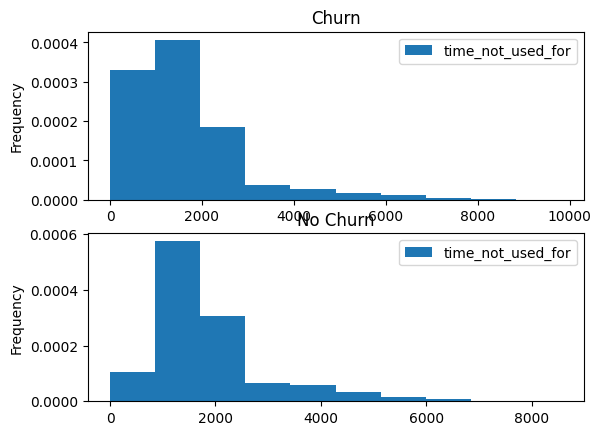

In [14]:
import matplotlib

test_dated[['time_not_used_for', 'predicted']].plot.hist(by=['predicted'], density=True, stacked=True)

Not sure what exactly happened with the charting element, but we can clearly see (as expected) that customers who have churned have a **much lower** `time_not_used_for`, which represents the number of days between when they first made the account and when it was last maintained. This of course means that a bigger `time_not_used_for` means that they have been consistently using the account!

# Part 6: Marketing Strategies
We have ideated 2 different Marketing strategies for these customers, accounting for Infinite Investment System's existing marketing and products as advertised on their [site](https://www.inf-systems.com/)

## Marketing Strategy 1: Music and Money Mix
### Overview
The first marketing strategy involves promoting a subscription to an **educational workshop series** called “Music and Money”. These are virtual events for target customers using the Cash and TFSA products whose purpose is to create a fun, community space for clients to learn about financial practices, debt management, and connect with other clients. These workshops will be promoted on Infinite Investment Systems’ website, as well as on various social media platforms like Instagram, Facebook, TikTok and YouTube. 

### Implementation
There would be 3 phases to this strategy. 
- Firstly, we would collect personalized data about their clients (e.g. music preferences, financial goals, investment knowledge) and use this information to plan the agenda and activities in these workshops. 
    - These workshops would consist of a combination of educational topics, community-based activities and advising sessions, designed to cater a subset of the clients to better fit their needs. For example, a “group profile” could include people who are:
        - Beginner investors,
        - Potential mortgage clients,
        - and Country and pop music lovers.
- In the second phase, we then schedule these workshops at convenient times for the target segment. Typically this would mean evenings or weekends since this target demographic would be unavailable during work hours.
- Finally, we host the Music and Money workshops and collect participant feedback to further refine the events.

### Reasoning
As these workshops are held virtually, they would be more attractive and accessible to millennial clients, specifically those who have just entered the workforce. It is well known that a good way to reduce churn and increase customer lock-in is personalization, which allows us to fully meet our customer's needs. These workshops thus serve the important goal of being a place to maintain deeper connections with clients, understand their financial needs, and collect improvement insights. 

Furthermore, since this strategy focuses on customers who are likely to not have a partner and do their finances independently, creating a community space can make this client experience more enjoyable. 


## Marketing Strategy 2: The Resonance for Renewal Initiative
The second marketing strategy is an **environmental philanthropic CSR marketing strategy** which aims to appeal to the target segment’s charitable financial habits. Specifically, since millennial customers are [known for supporting environmental causes](https://www.investopedia.com/articles/personal-finance/021914/money-habits-millennials.asp), this campaign will encourage customer retention. The campaign will be called “Resonance for Renewal” which communicates Infinite Investment Systems’ commitment to supporting ESG initiatives, with a catchy musical twist. 

### Implementation
- Firstly, Infinite Investment Systems should partner with environmental organizations to carry out initiatives to protect and reverse damage to the environment. These include actions such as planting trees to regrow forests. The company would be giving funding to reforestation Canadian non-profits like One Tree Planted and Tree Canada.
- Once these partnerships have been established, an email marketing and social media campaign will be launched. This campaign will consist of regular educational posts, videos, and email newsletters  about renewable practices and the purpose of the Resonance for Renewal campaign.
- To spread awareness about this campaign and foster client relationships, customers will be encouraged to engage with social media and email marketing posts about renewable practices. For example, commenting, sharing, or liking the post will drive donations of a certain amount to the non-profit partners, thus incentivizing their efforts in spreading this information. 

### Analysis
Since millennials are highly concerned about ESG issues, actively contributing to protecting the environment will boost Infinite Investment Systems Ltd’s reputation. The target demographic often chooses products from companies based on CSR reputations, so conducting ethical and ESG-related initiatives will encourage millennials to retain their business with the company long term. 

# Part 7: Parting Thoughts & Reflection

## Challenges Faced and Valuable Takeaways

**One Hot Encoding**: One of the biggest challenges we faced was figuring out how to one-hot encode our categorical columns. Within the dataset, there are a few columns that seem to contain string data, but still function like a category with a substantial number of entries sharing the same string. With large amounts of categories, this became especially troublesome as the One Hot encoding would result in a significant increase in the dimension of the dataframe. To overcome this challenge we ended up employing 2 methods of truncation - choosing to limit the number of categories we created, and ensuring that any categories created had enough data to have substance and be meaningful.

**MICE Algorithm**: Another big technical hurdle was the MICE algorithm. Originally, we had planned to use the MICE alogrithm on the One Hot encoded dataframe. However, we quickly ran into issues where the algorithm wouldn't finish even after 30 minutes of execution time! This was mainly because the algorithm had to process 250+ columns and the computation required to account for all those columns was probably excessive. In the end we choose to forgo the One Hot encoded columns and go with only the numerical ones, which could have lead to some inaccuracy. However, it seems that the use of Random Forest and Bagging mitigated the potential effects of this.

**Column Categorization**: Since we were a bit unfamiliar with the one-hot encoding method, we also faced initial problems where seemingly categorical columns being difficult to process. After careful examination, we realized that our filter for categorical columns was also including date columns, resulting to hundreds of thousands of columns being generated after the one-hot encoding method, ultimately crashing the kernel. Additionally, the functions we used to check the data types of columns initially were not accurately filtering the columns due to mixed data types being present - for instance we had problems where columns seemingly looked numerical in the `history.csv` but were actually categorial with mixed types in `test.csv`. Ultimately, we ended up doing a secondary check to ensure that the columns were properly filtered. 

**Google Colab Limitations**: Our team had trouble with Google Colab, notably due to errors when we tried editing the same document at once. Colab did not update in real time, meaning that it was challenging for our team to work on the same document at the same time. Ultimately, we ended up splitting the work up across a few files so we could all work without interruption. 

Additionally, we later ran into issues with RAM limitations. Especially after the One Hot encoding and trying to run MICE, the Google Python Kernel would often give out due to a lack of RAM. We had to move the entire notebook off the cloud so we were able to finish running the algorithm.

## Areas of Improvement
Figuring out a more efficient way to categorize the columns into numerical and categorical columns would be our next step. Furthermore, additional investigation into different training models and pre-processing steps would be beneficial for our next data science project, since many decisions about the process were made based on feasibility of implementing and understanding. As we obtain more experience, we predict that we will be able to take on more complex and effective pre-processing methods, and better extract insights from the data provided, without compromising it.

## Overall Learnings
Data Science is a fun and challenging area - but one that is definitely accessible to beginners with the right mindset and resources!

We first started out by learning about data frames which were discussed in the Data Preprocessing workshop, as well as how to view the rows / columns using python functions to help us visualize our data.

We also learned about the different Python libraries that can be leveraged and therefore utilized: Pandas, Ski-kit Learn, imbalanced learn, and Numpy within our solution. 

Additionally, our team enjoyed learning about preprocessing methods like One Hot Encoder and MICE. We also learned a lot about models like Random Forest. We gained a lot of knowledge about different ways of imputing data, such as mean/median/mode, MICE, and MissForest. 

We implemented binary classification (as mentioned in the Introduction to Classification CXC workshop) in order to predict a customer’s churn or no churn status. As a part of the Random forest model, we also leveraged the workshop’s information about decision trees to gain an in-depth understanding of what the model’s logic is (the use of decision nodes which provide high information gain) for multiple decision trees. 

Lastly, we learned about the importance of strong collaboration skills, project management (to keep our solution on track), and resilience in the face of roadblocks.  Our group was committed to increasing our data science knowledge, and we worked to share resources / information to help us achieve this goal. When we found ourselves unsure of an aspect, we reached out to our mentor to obtain guidance or utilized each other’s expertise to problem-solve. Our strong team dynamic made this challenge enjoyable and memorable!
